# Predicting music genre using Convolutional Neural Networks

## Downloading the dataset

First of all, let's download the data that we will be using. Since the files are quite heavy (>7 GB in total), we download in the Jupyter Notebook instead of having them directly. We then unzip the content of the files.

The whole dataset is entirely in the cloud, so it removes constraints about data space or anything.

**Note: Please note that the whole process may be a bit long (~15 minutes).**


In [1]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  14.2M      0  0:00:24  0:00:24 --:--:-- 18.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7323M  100 7323M    0     0  18.3M      0  0:06:39  0:06:39 --:--:-- 26.0M


In [2]:
!unzip fma_metadata.zip
!unzip fma_small.zip

Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  
Archive:  fma_small.zip
 bunzipping: fma_small/README.txt    
 bunzipping: fma_small/checksums     
 bunzipping: fma_small/000/000002.mp3  
 bunzipping: fma_small/000/000005.mp3  
 bunzipping: fma_small/000/000010.mp3  
 bunzipping: fma_small/000/000140.mp3  
 bunzipping: fma_small/000/000141.mp3  
 bunzipping: fma_small/000/000148.mp3  
 bunzipping: fma_small/000/000182.mp3  
 bunzipping: fma_small/000/000190.mp3  
 bunzipping: fma_small/000/000193.mp3  
 bunzipping: 

First of all, let's download the data that we will be using. Since the files are quite heavy (>7 GB in total), we download them in the Jupyter Notebook.

## Data exploration

In [0]:
import pandas as pd
import numpy as np
import os

The full information about the tracks, including the genre, can be found in the file `tracks.csv`. However,  in that sheet, the genre is stored as a number instead of a proper label ("Folk", "Rock", "Instrumental" ...). The link between the labels and the "code" can instead be found in the file `genres.csv`.

In [4]:
genres = pd.read_csv('/content/fma_metadata/genres.csv')
tracks = pd.read_csv('/content/fma_metadata/tracks.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# The first two lines are a bit buggy, so we remove them 
tracks.columns = ["track_id"] + list(tracks.iloc[0])[1:]
tracks = tracks.drop(tracks.index[[0,1]])
tracks = tracks.reset_index()
tracks[:5]

,index,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,6,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


If we take a look at the `tracks.csv` file, we notice that there are many columns that we do not need. In fact, we only need two pieces of information: the **track_id** (in order to know to which song we are referring) and the **corresponding genre**.

In [6]:
# We reduce the dataset in order to only keep the track ID and the genre
reduced_tracks = pd.DataFrame({'track_id': tracks.track_id, 'genres': tracks.genres})
reduced_tracks.track_id = reduced_tracks.track_id.astype(int)
reduced_tracks.set_index('track_id', inplace = True) 
reduced_tracks[:10]

,genres
track_id,
2,[21]
3,[21]
5,[21]
10,[10]
20,"[76, 103]"
26,"[76, 103]"
30,"[76, 103]"
46,"[76, 103]"
48,"[76, 103]"


In [7]:
len(reduced_tracks)

106574

There is another problem: we are working on a **small subset** of an original dataset, while the metadata refers to the **entirety of the original dataset** (which explains why the previous dataset has over $100,000$ rows). For this reason, we will need to remove all the lines that refer to tracks that are not present in our sample.

### Finding the track names

In [0]:
# We iterate over all files in the `fma_small` folder, in order to get their names
file_list = []

for root, dirs, files in os.walk("/content/fma_small"):  
    file_list += [file_name for file_name in files]

file_list = file_list[2:]

In [0]:
# We then remove the '.mp3' extension and take the remaining name
track_list = []

for file_name in file_list:
  track_id = int(file_name.split('.')[0])
  track_list += [track_id]

 As a sanity check, we can see that the number of track names we have is indeed equal to the total number of tracks:

In [10]:
len(track_list)

8000

We can then use those track names to reduce the length of our dataset to the expected $8,000$ rows.

In [11]:
reduced_tracks = reduced_tracks.reindex(track_list).sort_index()
reduced_tracks[:10]

,genres
track_id,
2,[21]
5,[21]
10,[10]
140,[17]
141,[17]
148,[1]
182,[27]
190,[17]
193,[17]


### Finding the right genre
The people who have created this dataset have made it so that each song belongs to **one genre** out of **eight possible genres**. However, in this dataset, we can see that some songs have several genres attributed to them – in that case, it means that all its genres are "subsets" of a single "parent" genre.

For most rows, the "parent" genre is the first genre listed (or the only genre mentionned). However, in certain cases, we find that there are **only subgenres** that are present, and that the "parent" genre is missing.

In the end, the goal of this section is to only keep the "parent" genre, which is supposed to be unique, for every track we have in our dataset.

In [0]:
genres.top_level = genres.top_level.astype(int)
genres.genre_id = genres.genre_id.astype(int)
genres.set_index('genre_id', inplace = True)

In [0]:
def parent_genre(genre_list):
  
  """
  This is the function we apply on the `genres` column.
  We replace every genre by its parent genre (if it exists, otherwise we change nothing).
  
  Afterwards, for a given row, if all parent genres are the same, then we remove
  the list and keep the first element only.
  """
  
  genre_list = genre_list[1:-1].split(',')
  genre_list = [int(genres.loc[int(x)].top_level) if int(x) in genres.index else int(x) for x in genre_list]
  
  if len(set(genre_list)) == 1:
    return genre_list[0]
  
  else:
    return genre_list



reduced_tracks.genres = reduced_tracks.genres.apply(parent_genre, 1)

In [14]:
reduced_tracks[:10]

,genres
track_id,
2,21
5,21
10,10
140,17
141,17
148,38
182,12
190,17
193,17


Now, we just need to replace the genre code with the proper genre name.

In [15]:
reduced_tracks.genres = reduced_tracks.genres.apply(lambda x: genres.loc[x].title)
reduced_tracks[:10]

,genres
track_id,
2,Hip-Hop
5,Hip-Hop
10,Pop
140,Folk
141,Folk
148,Experimental
182,Rock
190,Folk
193,Folk


## Track transformation

From what we have seen, a very common approach to process sound files for Genre Recognition, either with CNN or other techniques, is to turn them into a mel spectrogram. This is what we do here, thanks to Librosa.

Here are a few other projects where the same approach was taken:
- http://deepsound.io/music_genre_recognition.html
- https://arxiv.org/pdf/1802.09697.pdf
- http://cs231n.stanford.edu/reports/2017/pdfs/22.pdf
- https://medium.com/@diegoagher/learning-music-genres-5ab1cabadfed
- https://arxiv.org/pdf/1709.04396.pdf

<br/>


Note: After installing Librosa, we install ffmpeg, because otherwise Librosa does not recognise .mp3 files.

In [17]:
!pip install librosa
!apt-get install ffmpeg

    100% |████████████████████████████████| 1.6MB 5.9MB/s 
    100% |████████████████████████████████| 327kB 9.0MB/s 
    100% |████████████████████████████████| 3.2MB 6.6MB/s 
    100% |████████████████████████████████| 16.1MB 1.8MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig i965-va-driver libaacs0 libasound2 libasound2-data libass9
  

In [0]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time

### Finding the file path for all songs

When looking at the file structure, we realise that the tracks are stored in 156 different subdirectories in total. Therefore, an important step is to manage to **find the proper subdirectory for every song**, in order to treat them with Python afterwards.

In [0]:
file_paths = []
folder_list = []

for folder in os.listdir(path='./fma_small/'):
  if len(folder) == 3:
    folder_list += [folder]
    file_paths += [folder + '/' + files for files in os.listdir('./fma_small/' + folder)]

We take advantage of this to add another column to our Pandas "tracks" dataframe: the full file name for every track. This helps us create the link between the track and its genre more easily.

In [24]:
# Add the file name to the Pandas dataframe
dir_tracks = {}

for directory in folder_list:
  dir_tracks.update({int(track_name[:-4]): directory + '/' + track_name for track_name in os.listdir('fma_small/%s' % directory)})
  
reduced_tracks['file_name'] = pd.Series(dir_tracks)
reduced_tracks[:10]

,genres,file_name
track_id,,
2,Hip-Hop,000/000002.mp3
5,Hip-Hop,000/000005.mp3
10,Pop,000/000010.mp3
140,Folk,000/000140.mp3
141,Folk,000/000141.mp3
148,Experimental,000/000148.mp3
182,Rock,000/000182.mp3
190,Folk,000/000190.mp3
193,Folk,000/000193.mp3


### Spectrogram generation

In [0]:
def mel_spect(file_name, file_path = '/content/fma_small/'):
  
  song, sampling_rate = librosa.core.load('%s%s' % (file_path, file_name))
  song_mel = librosa.feature.melspectrogram(song, sr = sr,
                                            n_fft = fft_window_points,
                                            hop_length = hop_size, n_mels = n_mels,
                                            fmax = fmax)
  return song_mel
  

def display_spect(mel_spec):
  
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(librosa.power_to_db(mel_spec,
                                                ref=np.max),
                            y_axis='mel', fmax=8000,
                            x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel spectrogram')
  plt.tight_layout()

### Visualisation of the spectrograms

In [0]:
# parameters for calculating spectrogram in mel scale
sr = 22050
fmax = 10000 # maximum frequency considered
fft_window_points = 512
fft_window_dur = fft_window_points * 1.0 / sr # 23ms windows
hop_size = int(fft_window_points/ 2) # 50% overlap between consecutive frames
n_mels = 64

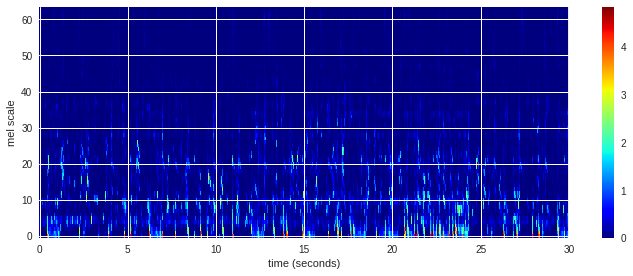

In [22]:
example_mel_spectrogram = mel_spect('/000/000002.mp3')
plt.figure(figsize=(10, 4))
plt.imshow(np.log(example_mel_spectrogram+1), origin="lower", aspect="auto", cmap="jet")
plt.xticks(np.linspace(0, 2587, 7), np.arange(0, 31, 5))
plt.xlabel("time (seconds)"); plt.ylabel("mel scale"); plt.colorbar(); plt.tight_layout()
# plt.savefig("example_mel_spectrogram_colorbar.png", dpi=300)
plt.show()

### Transforming all the songs into spectrograms

During our tests, we found one problem: the Librosa library seems to be **very slow** at loading the audio files, and then at transforming them into mel-spectrograms (2 seconds). For this reason, here is our method:
- We are only going to keep a **smaller fraction of the dataset** (this fraction can be changed by the user, but here, we kept 1000 songs). It is within this smaller fraction that we pick our train set, validation set, and test set.
- Then, we **precompute** the mel spectrogram for every song: since its output is a basic Numpy array, we can save them to an external file after computation. By doing this, and by reloading those Numpy arrays instead of computing them again, we can make the notebook load the spectrograms ~10 times faster.

The folder selection is going to be random, and we obviously initialise the seed in order to get **reproducible results**.

In [25]:
np.random.seed(0)
number_songs_kept = 1000

random_index = np.random.choice(reduced_tracks.index, number_songs_kept, replace = False)
small_tracks = reduced_tracks.reindex(random_index).copy()

small_tracks.groupby('genres').agg('count') # Check if distribution is okay

,file_name
genres,
Electronic,1000
Experimental,1000
Folk,1000
Hip-Hop,1000
Instrumental,1000
International,1000
Pop,1000
Rock,1000


Let us now precompute the mel spectrograms once and for all!
- In this case, since the mel spectrograms are basically two-dimensional numpy objects, we choose to store them in **text files**.
- The text files are stored in a separate folder (called `fma_small_np`). Their name depends on the source .mp3 file: for example, the text file "000002.txt" in the `fma_small_np` folder will correspond to the "000002.mp3" file in the `fma_small` folder.

Once the precomputation is done, we want to zip the `fma_small_np` file and store it in a shareable Google Drive link, in order to exploit it directly in a separate notebook.
- Since the precomputation will last between 40 and 50 minutes – even after drastically reducing the number of songs – we **do not want** to be running this if we do not have to.

In [0]:
# Import Google Drive
# The final file will be stored on the user's Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# At this point, we do not need those two folders
# We can remove them to gain space, if the number of songs kept
# by the user is very high.
!rm -r sample_data
!rm -r fma_metadata

In [39]:
# Note: on the full dataset, this code took more than four hours to run in total
source_path = 'fma_small/'
dest_path = 'gdrive/My Drive/Colab Notebooks/data/spectrogram/'
problem_tracks = []

start_time = time.time()

if not os.path.exists(dest_path):
  os.makedirs(dest_path)

for track_index in small_tracks.index:
  
  try:
    file_spectrogram = mel_spect(small_tracks.loc[track_index].file_name)
    norm_length = file_spectrogram.shape[1] // 10 * 10
    file_spectrogram = np.delete(file_spectrogram, range(norm_length, file_spectrogram.shape[1]), 1)
  
    np.savetxt(dest_path + str(track_index).rjust(6, '0') + '.txt', file_spectrogram)
    os.remove(source_path + small_tracks.loc[track_index].file_name) # Remove song track to gain space
    
  except KeyboardInterrupt:
    break
    
  except: # Two or three tracks generate "NoBackendError" problems, which we haven't
          # managed to fix yet  
    print('Problem with %s' % small_tracks.loc[track_index].file_name)
    problem_tracks += [track_index]

  
  print('Time: %f' % (time.time() - start_time))
  

NoBackendError: ignored

In [28]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
#uploaded = drive.CreateFile({'title': 'Colab Notebooks/data/spectrogram/Sample upload.txt'})
#uploaded.SetContentFile('fma_small_spectrogram/000207.txt')
#uploaded.Upload()
#print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
#downloaded = drive.CreateFile({'id': uploaded.get('id')})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 143, in main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 269, in run
    wheel_cache = WheelCache(options.cache_dir, options.format_control)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cache.py", line 186, in __init__
    self._ephem_cache = EphemWheelCache(format_control)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cache.py", line 164, in __init__
    self._temp_dir.create()
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/utils/temp_dir.py", line 73, in create
    tempfile.mkdtemp(prefix="pip-{}-".format(self.kind))
  File "/usr/lib/python3.6/tempfile.py", line 499, in mkdtemp
    prefix, suffix, dir, output_type = _sanitize_params(prefix, suffix, dir)
  File "/usr/lib/python3.6/tempfile.py", line 269, in _sanitize_params
    d

ModuleNotFoundError: ignored

In [0]:
# We now save the Pandas datasets as .csv files
# They can directly be downloaded on Google Colab's file manager
small_tracks.to_csv('small_tracks.csv')
reduced_tracks.to_csv('reduced_tracks.csv')